In [1]:
import numpy as np
import os
import pickle

from matplotlib import animation, pyplot as plt
from ripser import ripser  # Requires Numpy >= 1.22 ('pip install numpy==1.22')
from tifffile import imread, imshow

In [2]:
dataset = imread("Braided River/detrended.tiff")

# Min and max height value in dataset
min_value = 3928808
max_value = 21311037

<IPython.core.display.Javascript object>


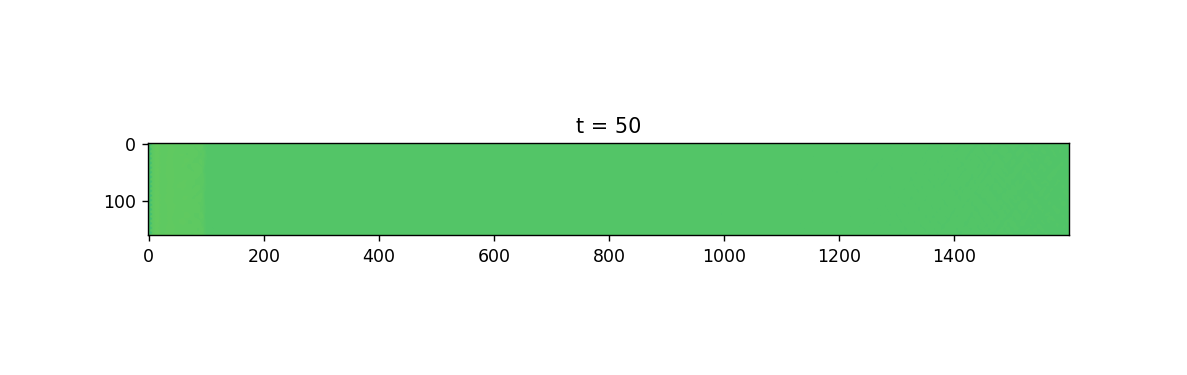

In [3]:
# Basic animation

%matplotlib notebook
%matplotlib notebook

fig = plt.figure("Animation of river bed elevation over time", figsize=(9.5, 3))

img = plt.imshow(dataset[0], vmin=min_value, vmax=max_value)

def animate(t):
    img.set_data(dataset[t])
    
    plt.title(f"t = {t}")
    
    return img

animation.FuncAnimation(fig, animate, frames=len(dataset), interval=10)

In [4]:
# Computes all local minima below max_height at time t
def compute_low_minima(t, max_height):
    print(f"t = {t}")
    
    points = []
    height_map = dataset[t]
    
    for i in range(1, len(dataset[t]) - 1):
        for j in range(1, len(dataset[t][i]) - 1):
            height = height_map[i][j]
            
            if height <= max_height:
                
                # Check if the point (i, j) is a local minimum
                if (
                    height <= height_map[i - 1][j - 1] and height <= height_map[i - 1][j] and height <= height_map[i - 1][j + 1] and
                    height <= height_map[i][j - 1] and height <= height_map[i - 1][j + 1] and
                    height <= height_map[i + 1][j - 1] and height <= height_map[i + 1][j] and height <= height_map[i + 1][j + 1]
                ):
                    points.append([i, j])
                    
    return points

In [5]:
max_height = 10000000

file_name = f"point_sets_with_max_height_{max_height}"

# If point sets not yet computed for this max_height, compute them (takes long)
if not os.path.exists(f"Point data/{file_name}.data"):
    point_sets_per_timestep = [compute_low_minima(t, max_height) for t in range(len(dataset))]
    
    with open(f"Point data/{file_name}.data", "wb") as f:
        pickle.dump(point_sets_per_timestep, f)
        
# If point sets already computed for this max_height, quickly retrieve them
else:
    with open(f"Point data/{file_name}.data", "rb") as f:
        point_sets_per_timestep = pickle.load(f)

<IPython.core.display.Javascript object>


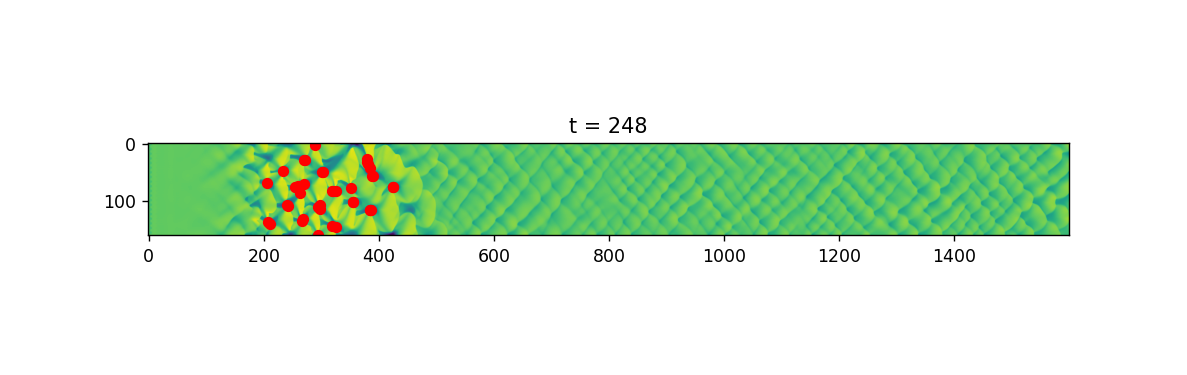

In [6]:
# Animation with low local minima highlighted

fig = plt.figure(f"Animation of river bed elevation and local minima lower than {max_height} over time", figsize=(9.5, 3))

img = plt.imshow(dataset[0], vmin=min_value, vmax=max_value)
scat = plt.scatter(x=[], y=[])

def animate(t):
    img.set_data(dataset[t])

    global scat
    scat.remove()
    scat = plt.scatter(x=[p[1] for p in point_sets_per_timestep[t]], y=[p[0] for p in point_sets_per_timestep[t]], c='r', s=30)

    plt.title(f"t = {t}")
    
    return img, scat

animation.FuncAnimation(fig, animate, frames=len(dataset), interval=10)

C:\Users\20182705\AppData\Local\Programs\Python\Python38\lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
C:\Users\20182705\AppData\Local\Programs\Python\Python38\lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
C:\Users\20182705\AppData\Local\Programs\Python\Python38\lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


<IPython.core.display.Javascript object>


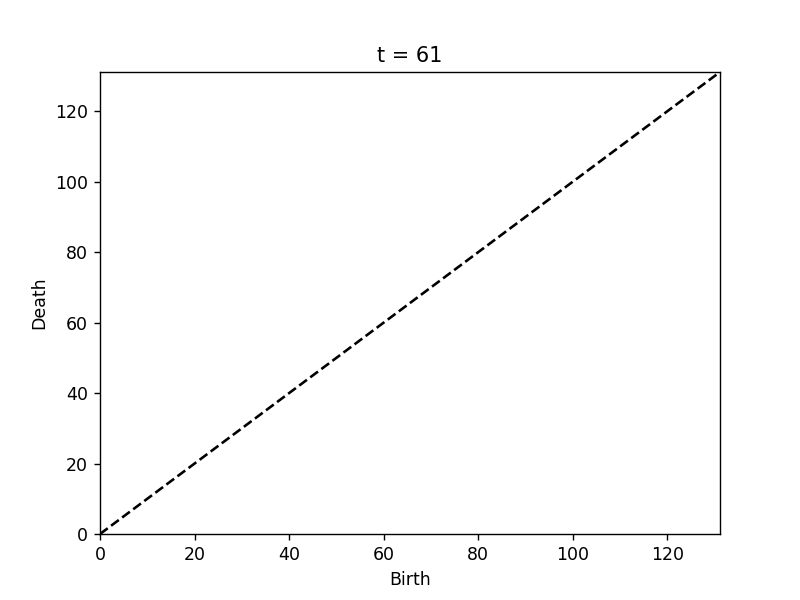

In [7]:
# Animation of 1-dimensional persistence diagram over time

first_persist_diagram_per_timestep = []
for t in range(len(dataset)):
    if point_sets_per_timestep[t]:
        first_persist_diagram_per_timestep.append(ripser(np.array(point_sets_per_timestep[t]))['dgms'][1].tolist())
    else:
        first_persist_diagram_per_timestep.append([])
        
fig = plt.figure(f"Animation of persistence diagram of local minima lower than {max_height} over time")

plt.xlabel("Birth")
plt.ylabel("Death")

max_value = max([item for sublist in first_persist_diagram_per_timestep for subsublist in sublist for item in subsublist])
plt.xlim([0, max_value])
plt.ylim([0, max_value])

scat = plt.scatter(x=[], y=[])
diagonal = plt.plot([0, max_value], [0, max_value], c='black', linestyle = 'dashed')

def animate(t):
    first_persist_diagram = first_persist_diagram_per_timestep[t]
    
    global scat
    scat.remove()
    scat = plt.scatter(x=[p[0] for p in first_persist_diagram], y=[p[1] for p in first_persist_diagram], c='r', s=30)
        
    plt.title(f"t = {t}")
    
    return scat

animation.FuncAnimation(fig, animate, frames=len(dataset), interval=1)